## Usage example

The project is about:
1. downloading foreign exchange rates (foreign currency to BYN) from external API (and insert them into database)
2. calculating other values based on downloaded rate (*so there a DAG appears*) (and insert then into database)
3. creating a DAG from config file (where downloaded and calucalted items are described), saving to a file, exporting DAG image
4. exporting database table to file

This project uses [paradag](https://github.com/xianghuzhao/paradag) Python package for creating DAG.

In [1]:
from subprocess import run

import pandas as pd
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set(rc={'figure.figsize': (10, 5)})

In [2]:
! python src/cli.py --help

Usage: cli.py [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  create-dag         Create DAG from tasks config file, save DAG and it's...
  export-table       Export `rates` table into CSV-file
  insert-data        Load DAG from file, run DAG for specified date, save...
  recreate-database  Recreate database tables


#### [Re]create database (SQLite)

In [3]:
! more sql\init\create_table_rates.sql 

DROP TABLE IF EXISTS rates;

CREATE TABLE rates (
        dt TEXT NOT NULL,
        currency_code TEXT NOT NULL,
        value REAL NOT NULL,
        sysmoment TEXT DEFAULT (DATETIME('now')),
        UNIQUE(dt, currency_code)
);


In [4]:
! python src/cli.py recreate-database --help

Usage: cli.py recreate-database [OPTIONS]

  Recreate database tables

Options:
  --help  Show this message and exit.


In [5]:
! python src/cli.py recreate-database

2022-10-23 13:10:05.785 | INFO     | __main__:recreate_database:23 - recreate_database invoked
2022-10-23 13:10:05.785 | INFO     | init_database:init_database:18 - >>> executing sql\init\create_table_currency_basket.sql
2022-10-23 13:10:05.812 | INFO     | init_database:init_database:18 - >>> executing sql\init\create_table_rates.sql


#### Create (and save) DAG from config

In [6]:
! more currencies.yml

downloadable:
  - USD
  - EUR
  - RUB
  - CNY
  - GBP
  - UAH
  - CHF
  - PLN
  - TRY
calculated:
  - code: CURR_BASKET
    sql_filename: calculate_currency_basket.sql  # = (RUB ** 0.5) * (USD ** 0.3) * (EUR ** 0.1) * (CNY ** 0.1)
    dependencies:
      - USD
      - EUR
      - RUB
      - CNY
  - code: EUR_TO_USD
    sql_filename: calculate_eur_to_usd.sql  # = EUR / USD
    dependencies:
      - USD
      - EUR
  - code: USD_TO_EUR
    sql_filename: calculate_usd_to_eur.sql  # = 1 / EUR_TO_USD
    dependencies:
      - EUR_TO_USD


In [7]:
! python src/cli.py create-dag --help

Usage: cli.py create-dag [OPTIONS]

  Create DAG from tasks config file, save DAG and it's image as files

Options:
  -c, --config-filepath PATH
  -o, --output-dag-filepath PATH
  -i, --output-image-filepath PATH
  --help                          Show this message and exit.


In [8]:
! python src/cli.py create-dag -c currencies.yml

2022-10-23 13:10:08.047 | INFO     | __main__:create_dag:32 - create_dag invoked with args: {'config_filepath': 'currencies.yml', 'output_dag_filepath': 'artifacts/dag.pkl', 'output_image_filepath': 'artifacts/dag.png'}


Exported DAG image:

![graph-schema](artifacts/dag.png)

#### Execute DAG (for one date)

In [9]:
! python src/cli.py insert-data --help

Usage: cli.py insert-data [OPTIONS]

  Load DAG from file, run DAG for specified date, save results into database

Options:
  -f, --dag-filepath PATH
  -d, --date [%Y-%m-%d]
  -t, --max-tasks INTEGER
  --help                   Show this message and exit.


In [10]:
! python src/cli.py insert-data -d 2022-09-01

2022-10-23 13:10:10.978 | INFO     | __main__:insert_data:44 - insert_data invoked with args: {'date': '2022-09-01', 'dag_filepath': 'artifacts/dag.pkl', 'max_tasks': 5}


*Note: database table has constraint on currency_code + date uniqueness*

In [11]:
for dt in pd.date_range(start='2022-09-02', end='2022-09-20'):
    run(['python', 'src/cli.py', 'insert-data', '-d', str(dt.date())], shell=True)

#### Export database table into file

In [12]:
! python src/cli.py export-table --help

Usage: cli.py export-table [OPTIONS]

  Export `rates` table into CSV-file

Options:
  -f, --output-filepath PATH
  --help                      Show this message and exit.


In [13]:
! python src/cli.py export-table

2022-10-23 13:10:42.720 | INFO     | __main__:export_table:52 - export_table invoked with args: {'output_filepath': 'artifacts/rates.csv'}


In [14]:
data = pd.read_csv('artifacts/rates.csv')
data['dt'] = pd.to_datetime(data['dt'])
data

,dt,currency_code,value,sysmoment
0,2022-09-01,CNY,0.370000,2022-10-23 10:10:11
1,2022-09-01,GBP,2.971500,2022-10-23 10:10:11
2,2022-09-01,PLN,0.539460,2022-10-23 10:10:11
3,2022-09-01,UAH,0.069189,2022-10-23 10:10:11
4,2022-09-01,USD,2.554600,2022-10-23 10:10:11
...,...,...,...,...
235,2022-09-20,CURR_BASKET,0.269000,2022-10-23 10:10:40
236,2022-09-20,CHF,2.625800,2022-10-23 10:10:40
237,2022-09-20,EUR_TO_USD,0.999448,2022-10-23 10:10:40
238,2022-09-20,PLN,0.537200,2022-10-23 10:10:40


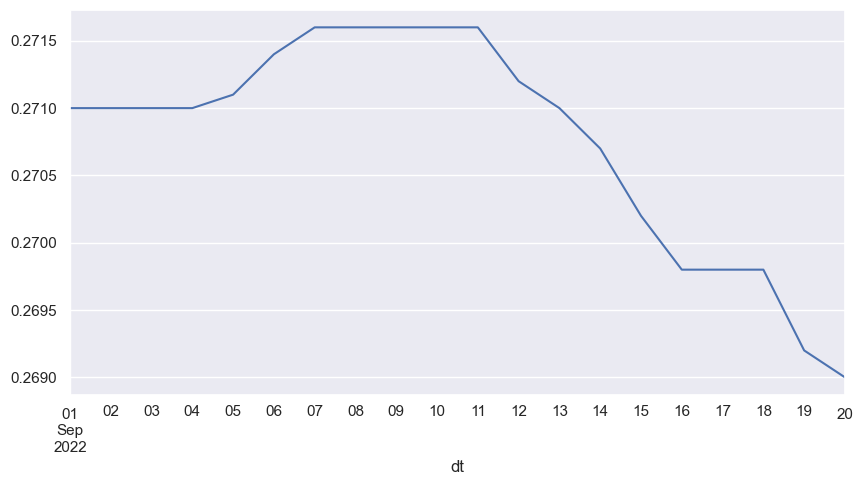

In [15]:
data[data['currency_code'] == 'CURR_BASKET'].sort_values('dt').set_index('dt')['value'].plot();